In [5]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd 
import math

In [20]:
look_up_8cell = {
    'Central Cell1':0b0000, 
    'Central Cell2':0b1000, 
    'Central Cell3':0b0100, 
    'Central Cell4':0b1100, 
    'Peripheral Cell1':0b0010, 
    'Peripheral Cell2':0b1010,
    'Peripheral Cell3':0b0110, 
    'Peripheral Cell4':0b1110, 
}

look_up_16cell = {
    'Central Cell1':0b0000, 
    'Central Cell2':0b1000, 
    'Central Cell3':0b0100, 
    'Central Cell4':0b1100, 
    'Peripheral Cell1':0b0001, 
    'Peripheral Cell2':0b1001,
    'Peripheral Cell3':0b0101, 
    'Peripheral Cell4':0b1101, 
    'Peripheral Cell5':0b0010, 
    'Peripheral Cell6':0b0011, 
    'Peripheral Cell7':0b1010, 
    'Peripheral Cell8':0b1011,
    'Peripheral Cell9':0b0110, 
    'Peripheral Cell10':0b0111, 
    'Peripheral Cell11':0b1110, 
    'Peripheral Cell12': 0b1111
}

def convert(cell_name):
    s = str(int(cell_name[-2:]))
    return cell_name[:-2] + s 

In [24]:



def read_cursed_csv(name): 
    df = pd.read_csv(name, sep=';')
    df = df.replace(',', '.', regex=True)
    return df

def extract_info(df, double=False): 
    pos = df[['Position X', 'Position Y', 'Position Z']].to_numpy().astype('float')
    vol = df['Volume'].to_numpy().astype('float')
    if double: 
        index = np.array([look_up_16cell[convert(key)] for key in df['Surpass Object']])
    else: 
        index = np.array([look_up_8cell[key] for key in df['Surpass Object']])
    emb = df['Emb'].to_numpy().astype('int')
    return pos, vol, index, emb

def check_cell_division(df, flag, last_round): 
    pos, vol, index, emb = extract_info(df, flag) 
    vol_data = [] 
    for e in [1, 2]:
        vols = [] 
        evol = vol[emb == e]
        eindex = index[emb == e]
        for r in range(0, last_round+1):
            for i in range(1 << r):
                m = ((eindex >> (4-r)) == i)
                d_vols = np.sum(evol[m]) # calculate volume of daughters 
                vols.append(d_vols)
        vols = np.array(vols)
        vol_data.append(vols)
    return np.array(vol_data) 


def print_binary_tree(arr):
    if len(arr)==0:
        return

    height = math.ceil(math.log2(len(arr) + 1))  # Calculate the height of the tree
    max_width = 2 ** (height - 1)  # Maximum width of the tree at the last level

    index = 0
    for level in range(height):
        level_length = 2 ** level  # Number of elements at the current level
        spaces_before = max_width // (2 ** (level + 1))  # Spaces before the first element
        spaces_between = max_width // (2 ** level)  # Spaces between elements at the current level

        line = "  " * spaces_before
        for i in range(level_length):
            if index < len(arr):
                line += '{:.2}'.format(arr[index])
                index += 1
                if i < level_length - 1:  # No trailing spaces after the last element on this level
                    line += " " * spaces_between

        print(line.center(max_width*3))  # Center the line to the max width

In [25]:
df8 = read_cursed_csv('Data/CellVolumes/8-cell.csv')
df16 = read_cursed_csv('Data/CellVolumes/16-cell.csv')
flag8 = False 
flag16 = True

In [26]:
sis_vols8 = check_cell_division(df8, flag8, 3)
sis_vols16 = check_cell_division(df16, flag16, 4)

In [27]:
Ns = [8, 16]
ratios = [[], []] 

for emb in [0, 1]: 
    for (i, v) in enumerate([sis_vols8, sis_vols16]):
        print('volume of cells')
        print_binary_tree(v[emb]/10e6)
        
        print('\n')
        print('ratio of sister cells')
        v_r = v[emb, 1:].reshape((int(len((v[emb])-1)/2), 2))
        ratio = v_r[:, 0]/v_r[:, 1]
        print_binary_tree(ratio)
        print('\n')
        
        ratios[i].append(ratio[-int(Ns[i]/2):])

volume of cells
              4.1       
         2.1    2.1     
   1.1  0.99  1.1  0.98 
0.66 0.41 0.57 0.42 0.64 0.46 0.54 0.44


ratio of sister cells
      0.99  
   1.1  1.1 
1.6 1.3 1.4 1.2


volume of cells
                              3.3               
                     1.6        1.7             
            0.82    0.76    0.86    0.84        
  0.46  0.36  0.43  0.33  0.49  0.37  0.44  0.4 
0.26 0.2 0.22 0.13 0.22 0.22 0.16 0.16 0.23 0.25 0.21 0.17 0.23 0.22 0.19 0.21


ratio of sister cells
              0.93      
         1.1    1.0     
    1.3  1.3  1.3  1.1  
1.3 1.7 1.0 1.0 0.92 1.3 1.0 0.93


volume of cells
              3.8       
         1.9    1.9     
  0.89  1.0  0.89  0.98 
0.49 0.4 0.54 0.47 0.48 0.41 0.54 0.44


ratio of sister cells
      1.0   
  0.88  0.91
1.2 1.1 1.2 1.2


volume of cells
                              3.7               
                     1.8        1.9             
             0.9    0.91    0.91    1.0         
  0.48  0.41  

In [28]:
r8, r16 = ratios 

r16_r = np.array(r16).reshape((2, 4, 2))

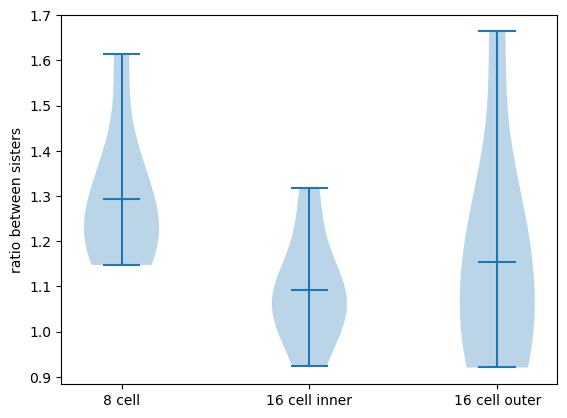

In [29]:
plt.violinplot(list(map(np.ravel, [r8, r16_r[:, :, 0], r16_r[:, :, 1]])), 
                showmeans=True, widths=0.4)
plt.xticks([1, 2, 3], labels=['8 cell', '16 cell inner', '16 cell outer'])
plt.ylabel('ratio between sisters')
plt.show() 

In [1]:
flat_ratios = np.concatenate([item for sublist in ratios for item in sublist])
m_ratio = np.mean(flat_ratios)
std_ratio = np.std(flat_ratios)

print('mean ratio: ', m_ratio)
print('std ratio: ', std_ratio)

NameError: name 'np' is not defined

In [48]:
# generate simulations for 128 cell stage 

def find_depth(index):
    return math.floor(math.log2(index + 1))

def total_cells(depth):
    return 2**(depth + 1) - 1


V0 = 4.0
index = 0
n_samples = 12 

total = total_cells(7)

samples = [] 

for j in range(n_samples): 
    vols = [V0] # volume of cells at each stage in a breath first traversal order 
    for index in range(128): 
        V = vols[index]
        n = find_depth(index)
        m = 1 if n < 3 else m_ratio if n < 5 else 1
        r = m + np.random.normal(0, std_ratio)
        f1 = r/(1+r)
        f2 = 1 - f1 
        V1 = f1*V
        V2 = f2*V 
        vols.extend([V1, V2])
    samples.append(vols)

In [49]:
print('vols of first 4 rounds of cell divisions: (in mm^3)')
print_binary_tree(vols[:total_cells(4)])

vols of first 4 rounds of cell divisions: (in mm^3)
                              4.0               
                     1.9        2.1             
             0.99    0.88    1.1    1.0         
  0.38  0.61  0.35  0.53  0.54  0.57  0.44  0.59
0.2 0.17 0.36 0.25 0.19 0.16 0.3 0.23 0.3 0.24 0.3 0.27 0.22 0.22 0.35 0.25


In [50]:
inner_cells_index = [0b0000, 0b1000, 0b0100, 0b1100]
inner_cells = [] 
outer_cells = []

for vols in samples: 
    last_round = vols[total_cells(6):] 
    inner_cells.append([v for (i, v) in enumerate(last_round) if (i >> 3) in inner_cells_index])
    outer_cells.append([v for (i, v) in enumerate(last_round) if (i >> 3) not in inner_cells_index])

In [51]:
np.median(inner_cells, axis=-1)

array([0.03293848, 0.03037735, 0.03066357, 0.03198249, 0.03221451,
       0.03278812, 0.03360144, 0.03200583, 0.03408402, 0.0318597 ,
       0.03260685, 0.02813234])

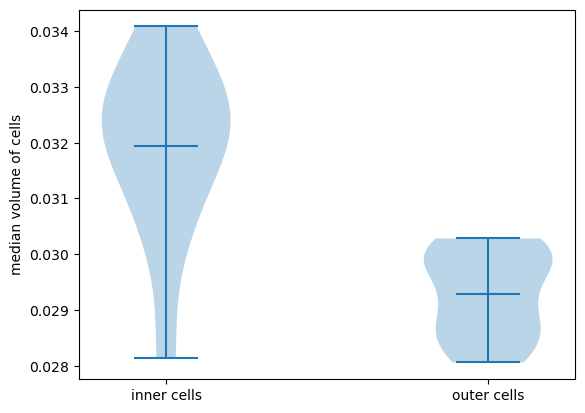

In [52]:
m_inner_cells = np.median(inner_cells, axis=-1)
m_outer_cells = np.median(outer_cells, axis=-1)

plt.violinplot([m_inner_cells, m_outer_cells], showmeans=True, widths=0.4)
plt.xticks([1, 2], labels=['inner cells', 'outer cells'])
plt.ylabel('median volume of cells')
plt.show() 

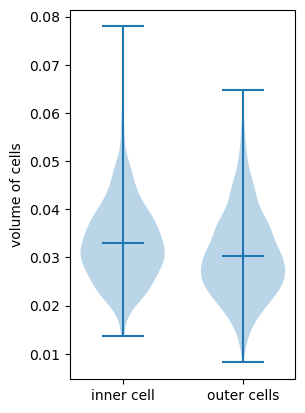

In [66]:
inner_cells = np.array(inner_cells).flatten()
outer_cells = np.array(outer_cells).flatten()

plt.violinplot([inner_cells, outer_cells],
                showmeans=True, widths=0.7)
plt.xticks([1, 2], labels=['inner cell', 'outer cells'])
plt.ylabel('volume of cells')
plt.gca().set_aspect(40)
plt.show() 